# Más sobre evaluación de modelos y selección de features (cuarta parte)

Vimos que el AUC de nuestros modelos fluctua naturalmente por el azar involucrado en armar los folds. Una buena pregunta es la siguiente: **¿podemos estar seguros de que a pesar de esas fluctuaciones nuestro modelo es mejor que el nivel chance?**

Por ejemplo, si evaluamos nuestro modelo con validacion cruzada y obtenemos AUC=0.67... **¿cómo podemos saber si no tuvimos suerte en el armado de los folds, pero en realidad nuestro nivel de clasificación es indistinto del azar?**

La forma de responder esta pregunta es la siguente: construyamos un modelo sobre el cual podamos afirmar realmente que el nivel de clasificación es indistinto del azar, usemos validación cruzada sobre este modelo, miremos cómo fluctua el AUC y comparemoslo con las fluctuaciones de nuestro modelo.

Seguimos trabajando con los datos de INTA, así que repetimos el proceso para cargarlos.

In [ ]:
# Como siempre, tratamos de traer todos los paquetes al ppio
from google.colab import drive # Para montar nuestro drive en la consola
import matplotlib.pylab as plt # Para gráficos
import numpy as np # Para manejo de arrays, operaciones matemáticas, etc.
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar
import pandas as pd # Para manejo de base de datos

# Traemos los datos
drive.mount('/content/drive') # Montamos nuestra unidad de Google Drive

filename = '/content/drive/My Drive/LaboDatos2021/datosDiariosSanFernandoINTA.xls'

d = pd.read_excel(filename) # Levantamos los datos, en este caso, con el método pd.read_excel


Mounted at /content/drive


Luego, filtramos el dataframe descartando columnas con datos faltantes, seleccionamos un subconjunto de columnas, y las renombramos.

In [ ]:
vars = ['Precipitacion_Pluviometrica','Temperatura_Abrigo_150cm',	'Temperatura_Abrigo_150cm_Maxima',	'Temperatura_Abrigo_150cm_Minima', 'Temperatura_Suelo_10cm_Media', 'Tesion_Vapor_Media',	'Humedad_Media', 'Humedad_Media_8_14_20',	'Rocio_Medio', 'Velocidad_Viento_200cm_Media', 'Velocidad_Viento_1000cm_Media', 'Velocidad_Viento_Maxima', 'Horas_Frio',	'Unidades_Frio']
dictvars = {'Precipitacion_Pluviometrica':'precipitacion','Temperatura_Abrigo_150cm':'var1',	'Temperatura_Abrigo_150cm_Maxima':'var2',	'Temperatura_Abrigo_150cm_Minima':'var3', 'Temperatura_Suelo_10cm_Media':'var4', 'Tesion_Vapor_Media':'var5',	'Humedad_Media':'var6', 'Humedad_Media_8_14_20':'var7',	'Rocio_Medio':'var8', 'Velocidad_Viento_200cm_Media':'var9', 'Velocidad_Viento_1000cm_Media':'var10', 'Velocidad_Viento_Maxima':'var11', 'Horas_Frio':'var12',	'Unidades_Frio':'var13'}

d_filtrado = d[vars].dropna().copy() # Nos quedamos con ciertos campos del data set, para facilitar el trabajo. Y para limitarlo.
                                                  # Notar que primero aplicamos el método .dropna() para eliminar filas que tengan alguna columna con NaN 
                                                  # Ademas, el metodo copy() nos asegura que estemos creando un nuevo dataframe 
d_filtrado.rename(dictvars, axis = 1, inplace = True)
                  

Finalmente, construimos una variable con las etiquetas de los días lluviosos.


In [ ]:
d_filtrado['llueveNollueve'] = 0 # empezamos con una columna llena de 0. 
indice =  d_filtrado['precipitacion'] > 0  # esto me da los valores del indice para los cuales hay precipitacion mayor a 0
d_filtrado.loc[indice, 'llueveNollueve'] = 1 # entonces para esos valores del indice pongo 1, porque en el dia correspondiente, llovio

d_filtrado['llueveNollueve'].value_counts()

0    695
1    324
Name: llueveNollueve, dtype: int64

# Modelo nulo

Supongamos que queremos construir un modelo que sepamos es incapaz de clasificar los datos por encima del nivel azar. Una forma de hacer esto es randomizando (shuffleando) las etiquetas. Si permutamos las etiquetas al azar, entonces rompemos la relación entre features y targets, y podemos asumir que no hay nada útil que el clasificador pueda aprender, de forma tal que el AUC de este modelo nos da una buena idea de lo que podemos obtener al nivel chance.

Veamos cómo se ve el ROC plot para datos con y sin randomización de labels.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Definamos la matriz X
campos = ['var1','var2','var3','var4','var5','var6','var7','var8','var9','var10','var11','var12','var13'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = np.array(d_filtrado['llueveNollueve']) # Nuestra etiqueta sigue siende la misma de antes

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores = np.concatenate((scores,probas_test[:,1]),axis=0)
    indices = np.concatenate((indices,test_index),axis=0)
    targets = np.concatenate((targets,y_test),axis=0)

print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))




Estos son los valores AUC para cada fold:
[0.7115661317100166, 0.719535141117875, 0.7947980077476481, 0.7310459324847813, 0.7680980215827338]
Estos es el promedio de todos los AUC:
0.7450086469286109


Y ahora voy a todo pero permutando aleatoriamente todos los targets antes de empezar.

In [ ]:
from numpy.random import shuffle # para shufflear el vector

# Definamos la matriz X
campos = ['var1','var2','var3','var4','var5','var6','var7','var8','var9','var10','var11','var12','var13'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = np.array(d_filtrado['llueveNollueve']) # Nuestra etiqueta sigue siende la misma de antes

y_shuffled = y.copy() # creo una copia del vector de targets, porque shuffle lo pisa
shuffle(y_shuffled) # shuffleo

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y_shuffled) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores_shuffled = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices_shuffled = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets_shuffled = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y_shuffled): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores_shuffled  = np.concatenate((scores_shuffled ,probas_test[:,1]),axis=0)
    indices_shuffled  = np.concatenate((indices_shuffled ,test_index),axis=0)
    targets_shuffled  = np.concatenate((targets_shuffled ,y_test),axis=0)



print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))


Estos son los valores AUC para cada fold:
[0.5611510791366907, 0.5941339236303266, 0.5428887659103486, 0.4906474820143885, 0.489658273381295]
Estos es el promedio de todos los AUC:
0.5356959048146098


Ahora vamos a plotear las dos curvas ROC juntas para ver como se ven:

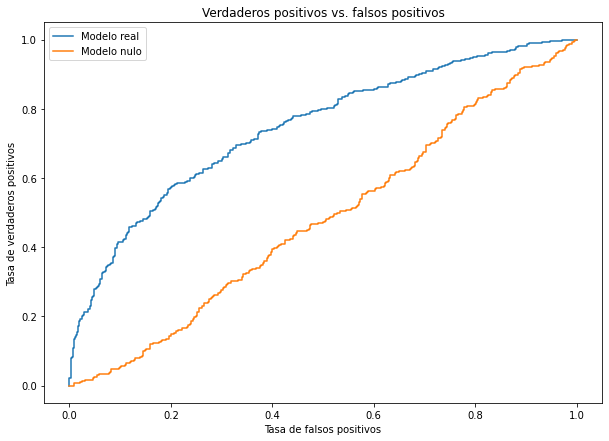

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# este codigo fue sacado del notebook de ROC AUC (clase 10) y sirve para visualizar la curva ROC

fpr, tpr, thresholds = roc_curve(targets, scores)
fpr_shuffled, tpr_shuffled, thresholds_shuffled = roc_curve(targets_shuffled, scores_shuffled)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr, label='Modelo real')
ax.plot(fpr_shuffled,tpr_shuffled, label='Modelo nulo')

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y
plt.legend()



# Test de permutación para AUC

La idea entonces es la siguiente:

1.   Obtengamos nuestro AUC para el modelo real (sin shufflear)
2.   Repitamos muchas veces el calculo de AUC shuffleando de forma distinta cada vez los labels
3.   Veamos la distribución de valores con y sin shufflear. Contemos la cantidad de veces que el AUC del modelo nulo supera al AUC del modelo real, y dividámoslo por la cantidad de shuffleados que hicimos. Esto lo podemos interpretar como la probabilidad de que el AUC de nuestro clasificador sea igual al del nivel chance.
4.   Típicamente introducimos un criterio arbitrario para declarar que nuestro clasificador es significativamente mejor que el nivel chance, por ejemplo, si esa probabilidad es < 0.05

Vamos a usar la función permutation_test_score de scikit-learn para hacer esto automáticamente. Como input de la función necesitamos:

*   Un objeto de tipo clasificador, que va a ser el clasificador cuya AUC queremos comparar con el modelo nulo.
*   Un objeto tipo cross-validation, que va a determinar el esquema de validación cruzada para computar AUC
*   Setear la metrica para medir la performance (obtenemos AUC eligiendo "roc_auc")
*   Los datos y etiquetas de nuestro modelo






In [ ]:
from sklearn.model_selection import permutation_test_score

regLog = LogisticRegression(penalty = 'none', max_iter=10000) # creamos un objeto clasificador
skf = StratifiedKFold(n_splits=5, shuffle=True) # creamos un objeto de cross-validation

AUC, AUC_shuffled, pvalue = permutation_test_score(regLog, X, y, scoring="roc_auc", cv=skf, n_permutations=100) # aca aplico la funcion 
# Notar que la función de arriba recibe como argumentos el clasificador (regLog) y la forma de hacer validación cruzada (skf), 
# además de los datos y el número de permutaciones que hacemos para construir nuestro modelo al azar.

print('Sin shufflear:')
print(AUC)
print('Modelo nulo (shuffleando):')
print(AUC_shuffled)
print('p-valor:')
print(pvalue)



Sin shufflear:
0.7429136690647483
Modelo nulo (shuffleando):
[0.46462126 0.50432001 0.46917162 0.52445663 0.49987306 0.49443968
 0.45524523 0.53674875 0.49140184 0.50686186 0.50626556 0.56871265
 0.50708183 0.5212168  0.53302366 0.44516706 0.45610646 0.44773243
 0.49945732 0.54096984 0.50045483 0.49559733 0.50685529 0.47331074
 0.47432243 0.48800014 0.47428403 0.52797904 0.51583011 0.54993809
 0.43687223 0.47796278 0.49734436 0.47747994 0.50336608 0.48691132
 0.49544653 0.44574952 0.52920206 0.49894542 0.49846534 0.50097157
 0.53286594 0.51193414 0.47669514 0.47220497 0.45968214 0.49051051
 0.45954171 0.49055064 0.46168442 0.52105562 0.48473264 0.49579552
 0.52842626 0.49510861 0.4617996  0.51674253 0.48280472 0.4895552
 0.53983363 0.49727553 0.51663773 0.48501799 0.54059664 0.44309768
 0.4693079  0.49479386 0.5253227  0.523226   0.47934837 0.50111442
 0.51819245 0.48146168 0.47899108 0.4989174  0.49804856 0.51504946
 0.53275318 0.4959816  0.48982499 0.48520199 0.46578272 0.52756122
 0

Vemos que el modelo parece ser significativamente mejor que el azar.

Podemos visualizar esto de otra forma graficando la distribucion de AUC obtenidas partiendo del modelo nulo vs. el valor obtenido del modelo real.

Text(0, 0.5, 'Probabilidad')

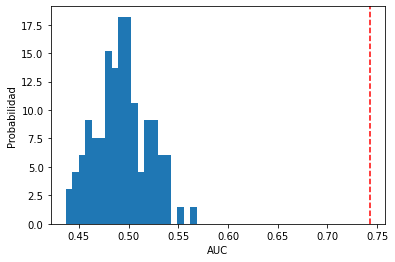

In [ ]:
fig, ax = plt.subplots()

ax.hist(AUC_shuffled, bins=20, density=True) # armo el histograma de valores, normalizado para tener la probabilidad
ax.axvline(AUC, ls='--', color='r') # una linea vertical para indicar el AUC sin shufflear (modelo real)
ax.set_xlabel("AUC") # nombre de eje x
ax.set_ylabel("Probabilidad") # nombre de eje y

# Para llevarse de este notebook

Lo principal para llevarse es la existencia de la funcion 

```
AUC, AUC_shuffled, pvalue = permutation_test_score(clf, X, y, scoring="roc_auc", cv=cv, n_permutations=100)
```
donde clf es un objeto tipo clasificador (hasta ahora, regresion logistica es el unico que vimos), X, y son matrices con features y labels, respectivamente, cv es un objeto de validacion cruzada, y n_permutations es la cantidad de permutaciones (shuffling) de labels que vamos a considerar.


# Preguntas extra

*   Si tenemos $N$ permutaciones, ¿cuál es el valor más pequeño que puede tomar el p-valor?
*   ¿Qué pasa si justo tuvimos mala suerte con la validacion cruzada para el AUC sin shufflear? ¿Convendría tomar el promedio de muchos AUC obtenidos de esta forma para estimar el p-valor?
*    Armar un clasificador "malo" a proposito (por ejemplo, elegir una o dos features que sospechen que son poco informativas para predecir la lluvia) y obtener el p-valor correspondiente. Comparar con el ejemplo en este notebook.

